In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from utils import * 
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = read_geant_data()
start_idx = 0 
end_idx = int((60/15)*24*21) # three weeks of data (same number of samples as abilene for 1 week)
data = data[start_idx:end_idx]
data = data/1e5 # scale to 1e5 bits

## Denoising Data

#### Moving Average Smoothing

In [3]:
window_size = 15

# Convert data to a pandas DataFrame for convenience
time_series_df = pd.DataFrame(data)

# Apply rolling mean to all columns
smoothed_df = time_series_df.rolling(window=window_size, min_periods=1).mean()

# Convert back to NumPy array if needed
moving_avg = smoothed_df.values


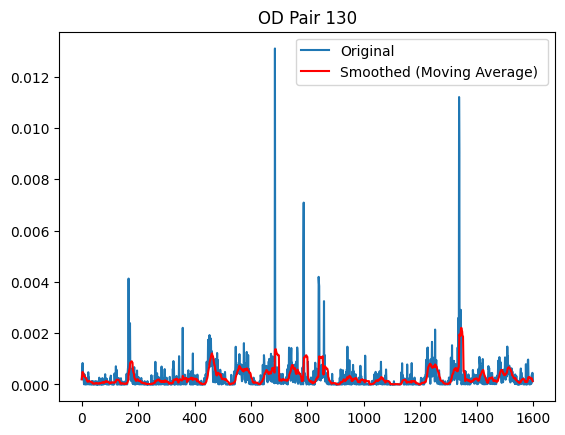

In [4]:
# Plot an example time series before and after smoothing
series_index = 130  # Choose a time series to visualize
plt.plot(data[:1600, series_index], label="Original")
plt.plot(moving_avg[:1600, series_index], label="Smoothed (Moving Average) ", color='red')
plt.title('OD Pair %d' % series_index)
plt.legend()
plt.show()

#### Exponential Moving Average Smoothing

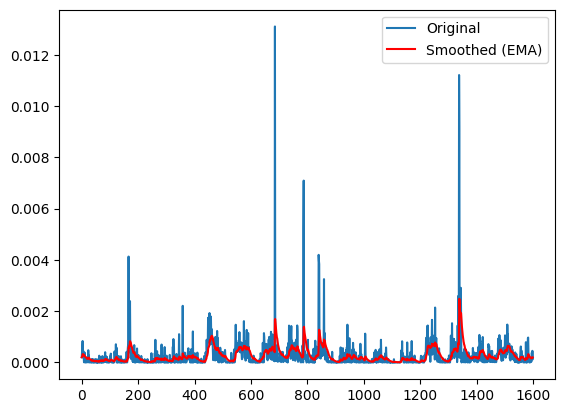

In [5]:
alpha = 0.1  # Smoothing factor
# Convert data to a pandas DataFrame
time_series_df = pd.DataFrame(data)

# Apply EMA to all columns at once
ema_df = time_series_df.ewm(alpha=alpha, adjust=False).mean()

# Convert back to NumPy array if needed
exp_ma = ema_df.values

series_index = 130  # Choose a time series to visualize
# Plot
plt.plot(data[:1600, series_index], label="Original")
plt.plot(exp_ma[:1600, series_index], label="Smoothed (EMA)", color='red')
plt.legend()
plt.show()

#### Low Pass Filter

Original Data Shape: (2016, 529)
Low Pass Filter Data Shape: (2016, 529)


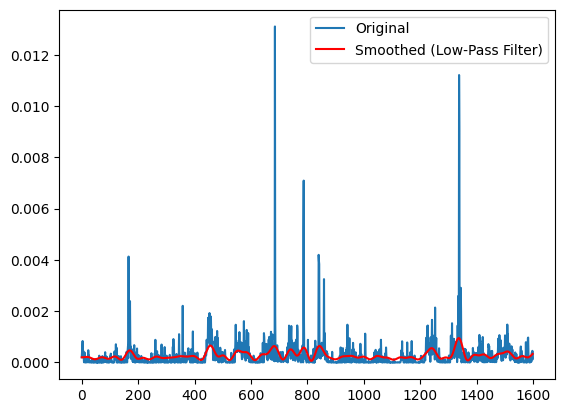

In [6]:
# Low-pass filter implementation
def low_pass_filter(signal, cutoff_frequency):

    # Perform Fourier Transform
    freq_data = np.fft.fft(signal)
    
    # Zero out high-frequency components
    freq_data[cutoff_frequency:] = 0
    freq_data[-cutoff_frequency:] = 0  # Mirror for negative frequencies
    
    # Inverse Fourier Transform to get back to time domain
    filtered_signal = np.fft.ifft(freq_data).real
    return filtered_signal

# Apply low-pass filter to all time series
cutoff_frequency = 50  # Choose an appropriate cutoff frequency
lp_filt_data = np.zeros_like(data)

for i in range(data.shape[1]):  # Iterate over each time series
    lp_filt_data[:, i] = low_pass_filter(data[:, i], cutoff_frequency)

# Check results
print("Original Data Shape:", data.shape)
print("Low Pass Filter Data Shape:", lp_filt_data.shape)

# Plot an example time series before and after filtering
series_index = 130  # Choose a time series to visualize
plt.plot(data[:1600, series_index], label="Original")
plt.plot(lp_filt_data[:1600, series_index], label="Smoothed (Low-Pass Filter)", color='red')
plt.legend()
plt.show()


Original Data Shape: (2016, 529)
Smoothed Data Shape: (2016, 529)


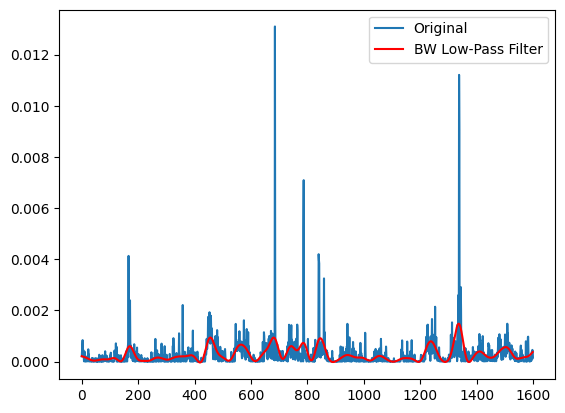

In [7]:
from scipy.signal import butter, filtfilt

# Butterworth filter design
def butter_lowpass_filter(data, cutoff, fs, order=4):
    
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalized cutoff
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply Butterworth low-pass filter to all time series
cutoff = 0.02  # Cutoff frequency (Hz)
sampling_frequency = 1.0  # Assuming 1 sample per unit time
bw_lp_filt_data = np.zeros_like(data)

for i in range(data.shape[1]):  # Iterate over each time series
    bw_lp_filt_data[:, i] = butter_lowpass_filter(data[:, i], cutoff, sampling_frequency)

# Check results
print("Original Data Shape:", data.shape)
print("Smoothed Data Shape:", bw_lp_filt_data.shape)

# Plot an example time series before and after filtering
series_index = 130  # Choose a time series to visualize
plt.plot(data[:1600, series_index], label="Original")
plt.plot(bw_lp_filt_data[:1600, series_index], label="BW Low-Pass Filter", color='red')
plt.legend()
plt.show()

#### Savgol Filter

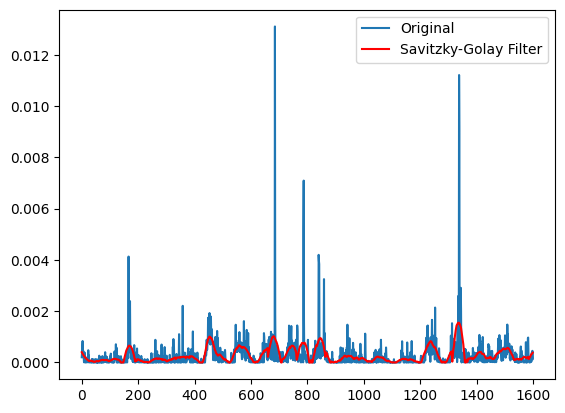

In [8]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
sg_filt_data = savgol_filter(data, window_length=50, polyorder=2, axis = 0)

# Replace negative values with 0
sg_filt_data[sg_filt_data < 0] = 0

# Plot
series_index = 130
plt.plot(data[:1600, series_index], label="Original")
plt.plot(sg_filt_data[:1600, series_index], label="Savitzky-Golay Filter", color='red')
plt.legend()
plt.show()

#### Wavelet-- to do

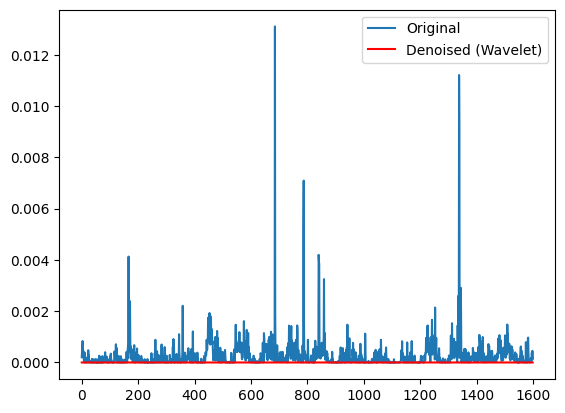

In [9]:
import pywt
import pywt.data

# Wavelet transform for denoising
coeffs = pywt.wavedec(data, 'db1', level=4)  # Decompose
threshold = np.sqrt(2 * np.log(len(data)))   # Universal threshold
coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]  # Thresholding
wavelet_data = pywt.waverec(coeffs, 'db1')  # Reconstruct

# Plot
series_index = 130
plt.plot(data[:1600, series_index], label="Original")
plt.plot(wavelet_data[:1600, series_index], label="Denoised (Wavelet)", color='red')
plt.legend()
plt.show()


## Compute MLUs of Denoised Data

-----computing mlu for moving_avg-----

Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-10
-----computing mlu for exp_moving_avg-----

-----computing mlu for low_pass_filt-----

-----computing mlu for bw_filt-----

-----computing mlu for savgol-----



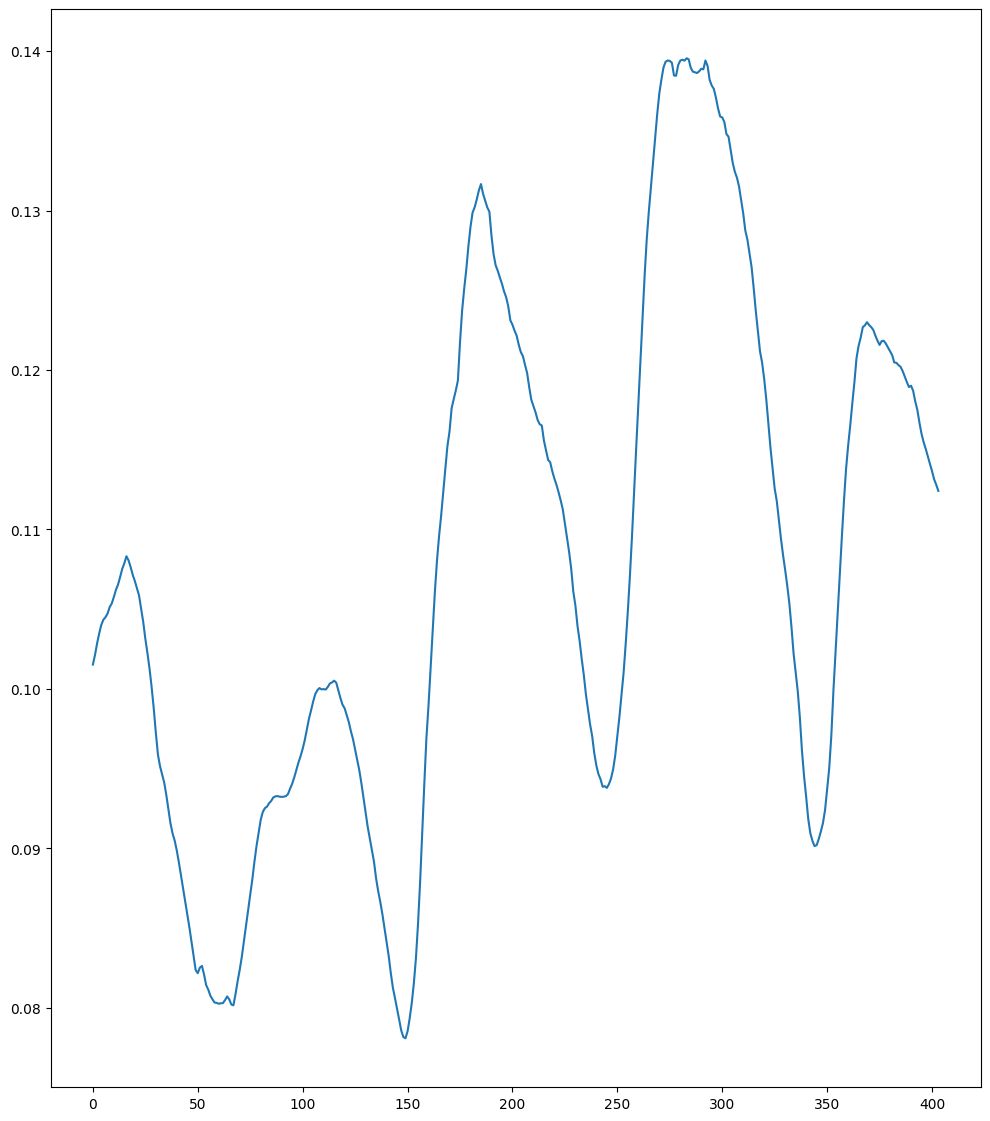

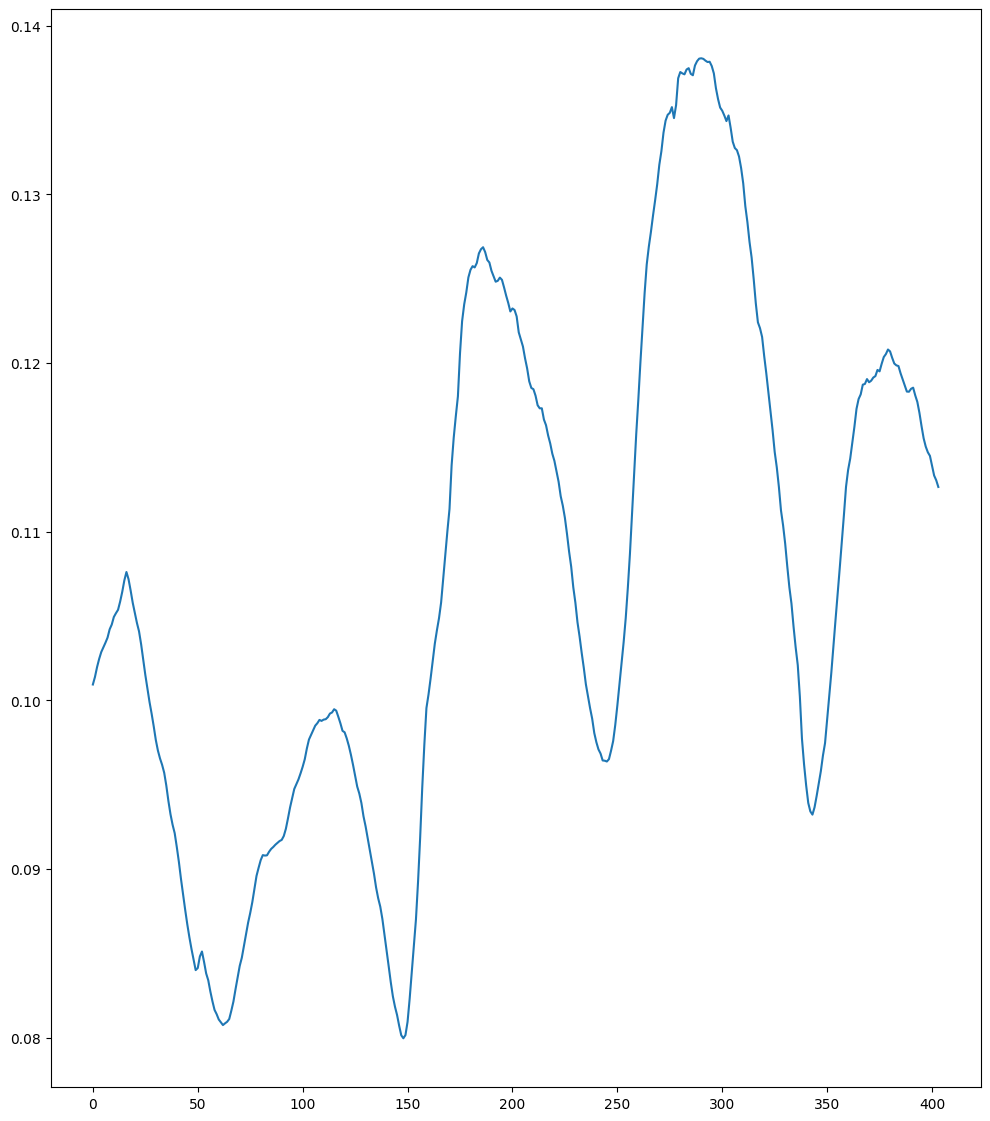

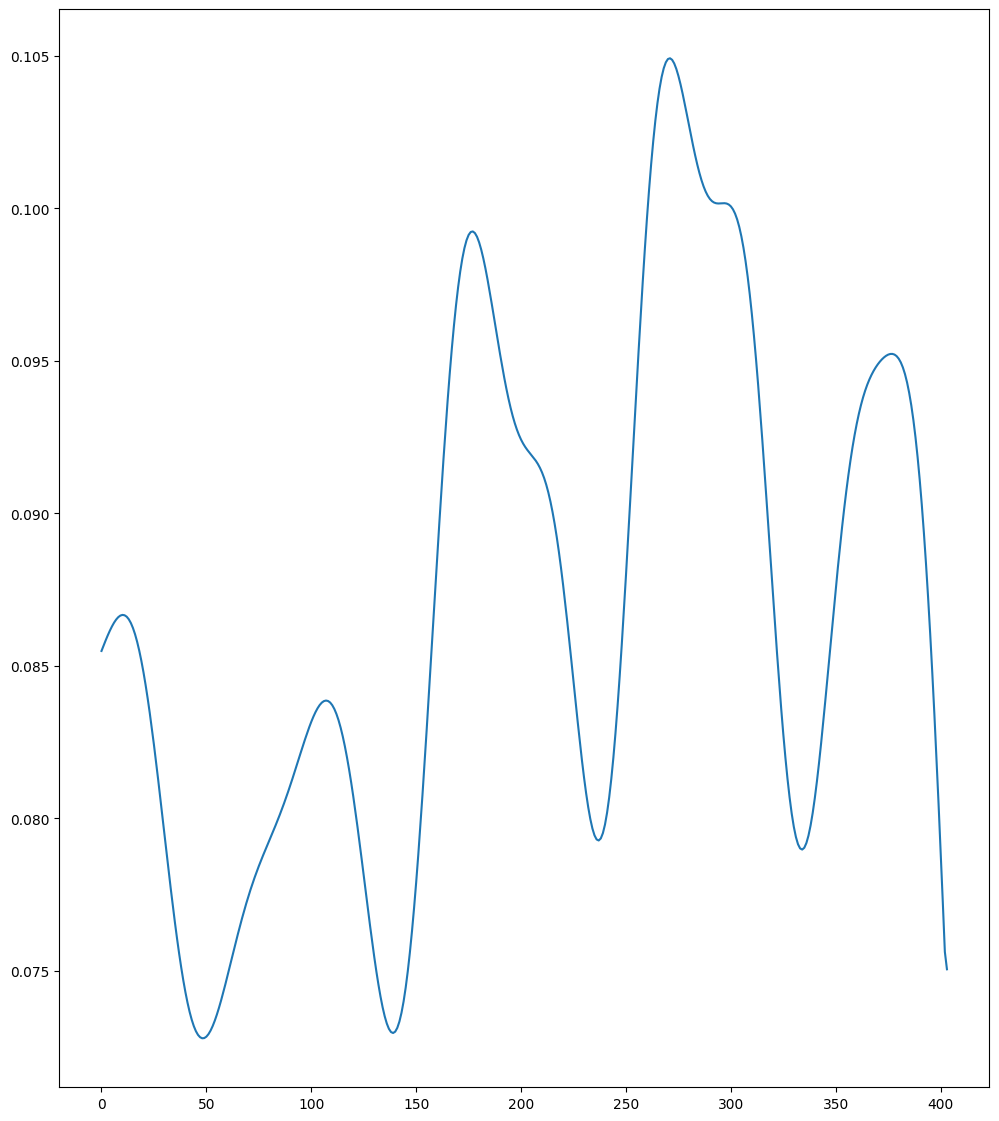

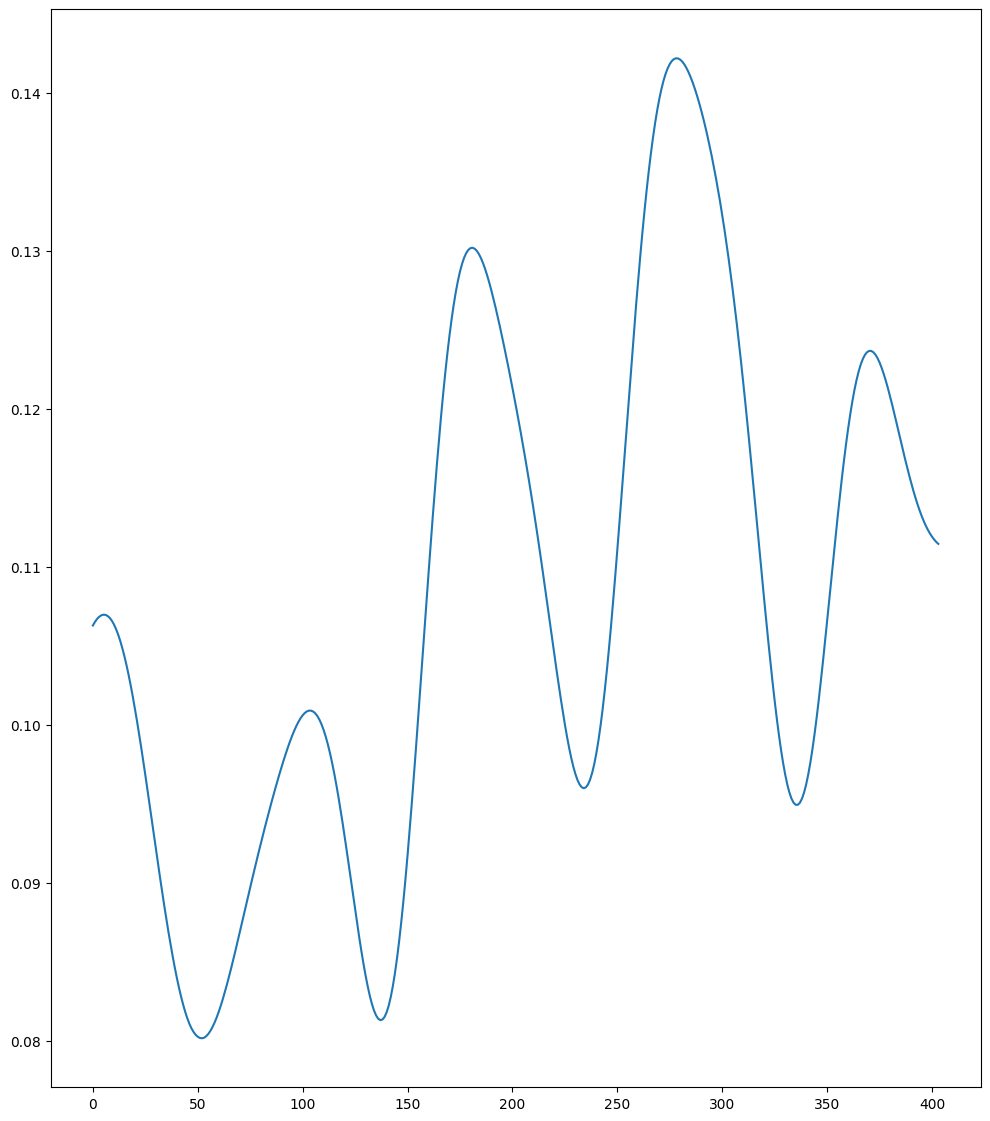

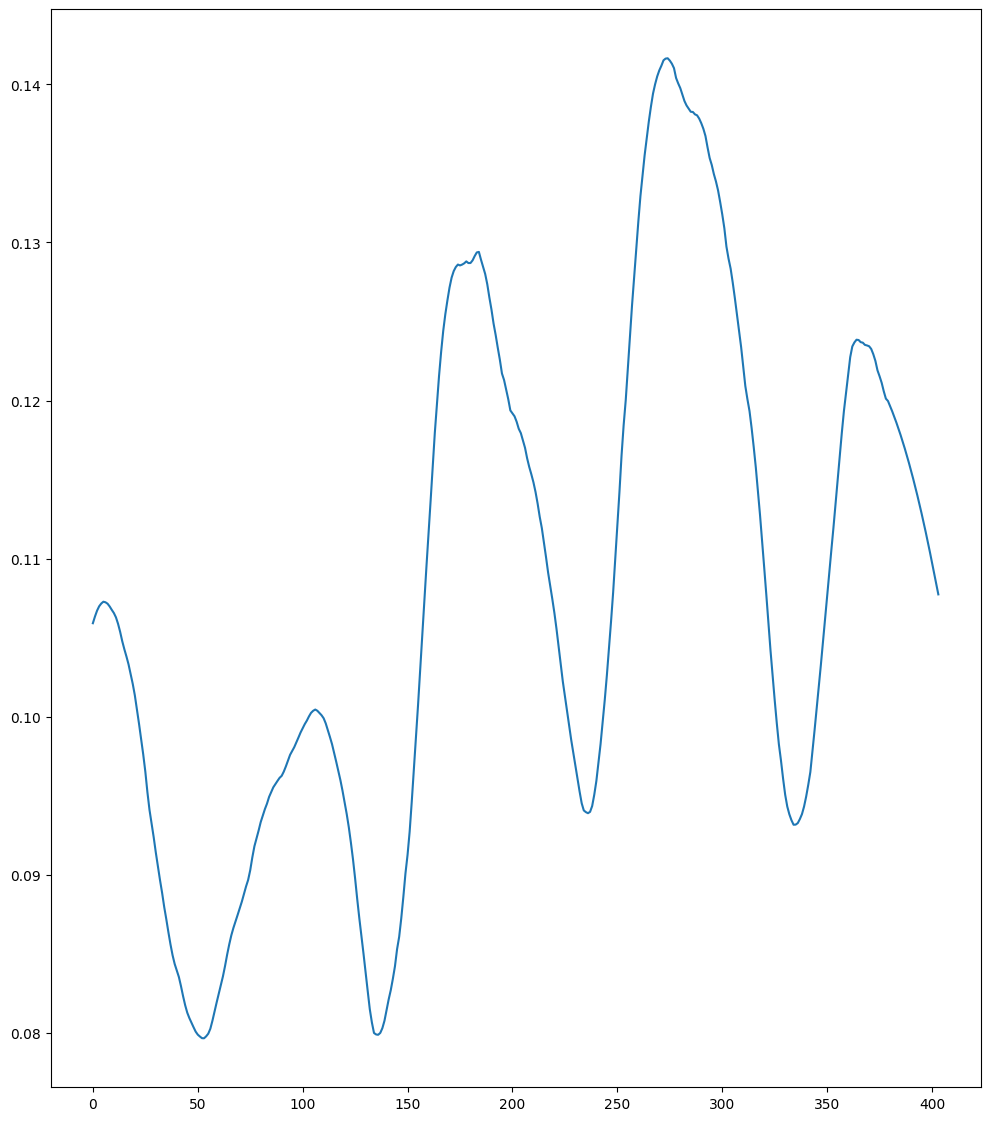

In [10]:
denoised_dict = {'moving_avg': moving_avg, 'exp_moving_avg': exp_ma, 
                 'low_pass_filt': lp_filt_data, 'bw_filt': bw_lp_filt_data, 'savgol': sg_filt_data}

training_len = int(len(data)*0.8) # for time purposes, we aren't computing on all 2016 datapoints, only the 20% testing points 

for method, data in denoised_dict.items():
    print(f'-----computing mlu for {method}-----\n')
    
    data = data[training_len:]
    
    # Compute baseline mlu 
    G = fully_connected_network(num_nodes=23, capacity=10)
    mlu_gt = np.empty((len(data), 1))

    for i in range(len(data)):
        D = data[i, :].reshape(23, 23)
        np.fill_diagonal(D,0)
        mlu_gt[i] = MinMaxLinkUtil(G,D)
    
    if np.any(np.isnan(mlu_gt)): 
        print('nans in mlus adjust parameters') 

    save_name = f'mlu_baseline\\mlu_baseline_geant_fc_{method}.npy'
    np.save(save_name, mlu_gt)
    
    fig, ax = plt.subplots(figsize = (12,14))
    ax.plot(mlu_gt)


## Plot MLU Baselines of Denoised Data vs. Original Data

## TM Prediction for Denoising Data

Create a dictionary of different denoised data values. Then use a for loop to streamline the prediction process and loop through each variable.

In [18]:
denoised_dict = {'exp_moving_avg': exp_ma, 
                 'low_pass_filt': lp_filt_data, 'bw_filt': bw_lp_filt_data, 'savgol': sg_filt_data}

# Parameters for plotting
dgreen = [0.05, 0.5, 0.05]  # RGB color for green
dgrey = [0.65, 0.65, 0.65]  # RGB color for grey
dred = [0.8, 0.1, 0.1] # RGB color for red
fontsize = 18

In [19]:
for method, denoised_data in denoised_dict.items():
    print(f'###### training for denoising method: {method} ######\n')
    # train, test split
    train_data, test_data = train_test_split(denoised_data, 0.8)
    window = 10

    # Min Max Normalize the train data and test data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_norm = normalize_matrix(scaler, train_data)

    scaler = MinMaxScaler(feature_range=(0,1))
    test_data_norm = normalize_matrix(scaler, test_data)

    # Window the dataset 
    trainX, trainY= create_dataset(train_data_norm, window) 
    testX, testY = create_dataset(test_data_norm, window) 

    # Define hyperparameters
    num_nodes = 23
    input_size = trainX.shape[2] # Number of features in input
    hidden_size = 200  # Number of features in hidden state
    learn_rate = 0.001 
    epochs = 100
    num_layers = 1
    batch_size = 32
    shuffle = False #don't want to lose the time dependency
    num_workers = 4  # Number of subprocesses to use for data loading

    # Create training dataset and dataloader
    train_loader = get_dataloader(trainX, trainY, batch_size, num_workers, shuffle)
    test_loader = get_dataloader(testX, testY, 1, num_workers, shuffle)

    # Train RNN 
    # Create Model 
    model = RNN(input_size, hidden_size, num_layers)

    # Create optimizer 
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    # Create loss function
    criterion = nn.MSELoss()

    # Train the model
    loss = train(model, train_loader, epochs, criterion, optimizer)

    # Test model
    model_outputs, _ = test(model, criterion, test_loader, testY)

    # Save the model 
    PATH = f'models\\geant_global_mse_{method}.pth'
    torch.save(model.state_dict(), PATH)

    # Save the model_outputs
    np.save(f'model_outputs\\geant_global_mse_{method}.npy', 
            model_outputs)
    
    # Plot heat maps 
    plot_and_save_heatmap(test_data_norm, model_outputs, num_nodes, save_path = 'Figs\\heat_maps', 
                        fig_name = f'normalized_model_predictions_{method}.png')
    
    inverse_preds = inverse_normalize_predictions(test_data, model_outputs) 
    plot_and_save_heatmap(test_data, inverse_preds, num_nodes, save_path = 'Figs\\heat_maps',
                          fig_name= f'inverse_normalized_model_predictions_{method}.png')
    
    # Compute difference
    difference = inverse_preds - denoised_data[len(train_data):-10]
    plot_and_save_diffmap(np.abs(difference), num_nodes, save_path = 'Figs\\heat_maps', fig_name = f'difference_heatmap_{method}.png')

    # Plot difference 
    fig, ax = plt.subplots(figsize = (7,6))
    pair = 130
    ax.plot(difference[:, pair], label = 'Difference', color = dred)
    ax.plot(inverse_preds[:, pair], label = 'Prediction', color = dgreen)
    ax.plot(denoised_data[len(train_data):-10, pair], label = 'Ground Truth', color = dgrey)
    ax.set_xlabel('Time Index')
    ax.set_ylabel('Difference = Prediction - Ground Truth')
    ax.set_title(f'Difference of Prediction vs. Ground Truth Denoised Data for {method}')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'Figs\\difference_plot_{method}.png', dpi = 300)
    plt.close()

    # Run MLU
    # Compute MCF on inverse normalized predictions
    mlu_preds, Nans = mlu_on_preds(inverse_preds, capacity = 10, topo = 'fc', num_nodes = 23)

    if Nans: 
        print('NaN values in mlu_preds, ending program')
        continue
    
    # Save MLUs
    np.save(f'mlu_baseline\\mlu_preds_geant_global_mse_{method}.npy', mlu_preds)

    # Load MCF baseline on original dataset (corresponding denoising method) -- fully connected network 
    mlu_gt =  np.load(f'mlu_baseline\\mlu_baseline_geant_fc_{method}.npy')
    #mlu_gt = mlu_gt[len(train_data):]

     # Plot mlu cdf and mlu comparison
    plot_and_save_ecdf(mlu_gt, mlu_preds, save_path = 'Figs\\ecdfs', 
                       fig_name=f'CDF_mlu_geant_global_mse_{method}_denoised.png', title = f'CDF of MLU - Predictions via {method}')
    plot_and_save_mlu_compare(mlu_gt, mlu_preds, save_path='Figs\\mlu_compare', 
                              fig_name=f'mlu_compare_geant_global_mse_{method}_denoised.png', title = f'MLU - Predictions via {method} vs. Ground Truth')
    plot_and_save_pdf(mlu_gt, mlu_preds, save_path = 'Figs\\pdfs', 
                      fig_name=f'PDF_mlu_geant_global_mse_{method}_denoised.png', title = f'PDF of MLU - Predictions via {method}')

    # Load MCF baseline on original dataset (not denoised) -- fully connected network
    mlu_gt = np.load('mlu_baseline\\mlu_baseline_geant_scaled_fc.npy')
    #mlu_gt = mlu_gt[len(train_data):]
    
    # Plot mlu cdf and mlu comparison
    plot_and_save_ecdf(mlu_gt, mlu_preds, save_path = 'Figs\\ecdfs', 
                       fig_name=f'CDF_mlu_geant_global_mse_{method}.png', title = f'CDF of MLU - Predictions via {method} vs. Original Data')
    plot_and_save_mlu_compare(mlu_gt, mlu_preds, save_path='Figs\\mlu_compare', 
                              fig_name=f'mlu_compare_geant_global_mse_{method}.png', title = f'MLU - Predictions via {method} vs. Ground Truth')
    plot_and_save_pdf(mlu_gt, mlu_preds, save_path = 'Figs\\pdfs', 
                      fig_name=f'PDF_mlu_geant_global_mse_{method}.png', title = f'PDF of MLU - Predictions via {method} vs. Original Data')
    


###### training for denoising method: exp_moving_avg ######

-----Begin Training------
Epoch [10/100], Loss: 9.9672e-04
Epoch [20/100], Loss: 3.2033e-04
Epoch [30/100], Loss: 2.2560e-04
Epoch [40/100], Loss: 1.8645e-04
Epoch [50/100], Loss: 1.5001e-04
Epoch [60/100], Loss: 1.2463e-04
Epoch [70/100], Loss: 1.1711e-04
Epoch [80/100], Loss: 1.2571e-04
Epoch [90/100], Loss: 1.0206e-04
Epoch [100/100], Loss: 1.0571e-04
Average (Normalized) Test Loss: 1.0391e-03
###### training for denoising method: low_pass_filt ######

-----Begin Training------
Epoch [10/100], Loss: 1.1261e-03
Epoch [20/100], Loss: 2.2932e-04
Epoch [30/100], Loss: 2.3815e-04
Epoch [40/100], Loss: 2.3804e-04
Epoch [50/100], Loss: 1.6159e-04
Epoch [60/100], Loss: 1.1229e-04
Epoch [70/100], Loss: 1.0751e-04
Epoch [80/100], Loss: 9.3436e-05
Epoch [90/100], Loss: 8.6232e-05
Epoch [100/100], Loss: 7.3719e-05
Average (Normalized) Test Loss: 1.5807e-03
###### training for denoising method: bw_filt ######

-----Begin Training------

In [17]:
# Load MCF baseline on original dataset (not denoised) -- fully connected network
mlu_gt = np.load('mlu_baseline\\mlu_baseline_geant_scaled_fc.npy')
#mlu_gt = mlu_gt[len(train_data):]
mlu_preds = np.load('mlu_baseline\\mlu_preds_geant_global_mse_moving_avg.npy')
method='moving_avg'
print(mlu_preds.shape)
# Plot mlu cdf and mlu comparison
plot_and_save_ecdf(mlu_gt, mlu_preds, save_path = 'Figs\\ecdfs', 
                    fig_name=f'CDF_mlu_geant_global_mse_{method}.png', title = f'CDF of MLU - Predictions via {method} vs. Original Data')
plot_and_save_mlu_compare(mlu_gt, mlu_preds, save_path='Figs\\mlu_compare', 
                            fig_name=f'mlu_compare_geant_global_mse_{method}.png', title = f'MLU - Predictions via {method} vs. Ground Truth')
plot_and_save_pdf(mlu_gt, mlu_preds, save_path = 'Figs\\pdfs', 
                    fig_name=f'PDF_mlu_geant_global_mse_{method}.png', title = f'PDF of MLU - Predictions via {method} vs. Original Data')
    

(394, 1)
